In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from matplotlib import pyplot as plt
from pylab import rcParams
import seaborn as sns
import matplotlib
from sklearn.utils import resample

%pylab inline
k=pd.read_csv("US_births(2018).csv")
pd.options.mode.chained_assignment = None  # default='warn'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/var/folders/8w/snj_8lln2bz87z87f46_k0t00000gn/T/ipykernel_27796/1184844124.py:19: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  k=pd.read_csv("US_births(2018).csv")


# Exploratory Data Analysis(EDA)

Create target variable, 1 if underweight according to medical norms, 0 if normal weight.

In [2]:
k['target'] = 0.0
k['target'][k['DBWT'] < 2500] = 1.0

Keeping predictors relevent to the birthweight, removing miscellaneous columns such as payment method, duplicate recode columns etc.

In [3]:
df=k[['BMI','CIG_0','DLMP_MM','DOB_MM','FAGECOMB','FRACE6','ILLB_R','ILOP_R','ILP_R','IP_GON','LD_INDL','MAGER','MM_AICU','MRAVE6','MTRAN','M_Ht_In','NO_INFEC','NO_MMORB','NO_RISKS','PRECARE','PREVIS','PRIORDEAD','PRIORLIVE','PRIORTERM','PWgt_R','SEX','WTGAIN','target']].copy()

Replacing the unreported values(encoded into dataset as 9,99,999, etc) with NaN.

In [4]:
df['BMI']=df['BMI'].replace(99.9, np.NaN)
df['CIG_0']=df['CIG_0'].replace(99, np.NaN)
df['FAGECOMB']=df['FAGECOMB'].replace(99, np.NaN)
df['FRACE6']=df['FRACE6'].replace(9, np.NaN)
df['ILLB_R']=df['ILLB_R'].replace(999, np.NaN)
df['ILOP_R']=df['ILOP_R'].replace(999, np.NaN)
df['ILP_R']=df['ILP_R'].replace(999, np.NaN)
df['IP_GON']=df['IP_GON'].replace('U', np.NaN)
df['LD_INDL']=df['LD_INDL'].replace('U', np.NaN)
df['MM_AICU']=df['MM_AICU'].replace('U', np.NaN)
df['MTRAN']=df['MTRAN'].replace('U', np.NaN)
df['M_Ht_In']=df['M_Ht_In'].replace(99, np.NaN)
df['NO_INFEC']=df['NO_INFEC'].replace(9, np.NaN)
df['NO_MMORB']=df['NO_MMORB'].replace(9, np.NaN)
df['NO_RISKS']=df['NO_RISKS'].replace(9, np.NaN)
df['PRECARE']=df['PRECARE'].replace(99, np.NaN)
df['PREVIS']=df['PREVIS'].replace(99, np.NaN)
df['PRIORDEAD']=df['PRIORDEAD'].replace(99, np.NaN)
df['PRIORLIVE']=df['PRIORLIVE'].replace(99, np.NaN)
df['PRIORTERM']=df['PRIORTERM'].replace(99, np.NaN)
df['PWgt_R']=df['PWgt_R'].replace(999, np.NaN)
df['WTGAIN']=df['WTGAIN'].replace(99, np.NaN)
df['ILLB_R']=df['ILLB_R'].replace(888, np.NaN)
df['ILP_R']=df['ILP_R'].replace(888, np.NaN)

## Feature Engineering
#### USE 'DLMP_MM','DOB_MM' TO calculate duration since last normal menses. Performing feature engineering in order to create metrics from the data which are related to the target variable. 

In [5]:
df['NMD']=df['DOB_MM']-df['DLMP_MM']
df.loc[df.NMD < 0, 'NMD'] = 12+df['NMD']

#keep only valid durations
df['NMD'] = df['NMD'].apply(lambda x : x if x >= 0 else np.NaN)

Drop 'DLMP_MM','DOB_MM' columns to remove duplicacy of data

In [6]:
df2=df.drop('DLMP_MM', axis=1)
df2=df2.drop('DOB_MM', axis=1)

Examine skewness of the data

In [7]:
df2.skew().sort_values(ascending=False)

/var/folders/8w/snj_8lln2bz87z87f46_k0t00000gn/T/ipykernel_27796/1575666287.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df2.skew().sort_values(ascending=False)


PRIORDEAD    26.574217
CIG_0         6.909061
PRIORTERM     3.576709
target        3.030436
FRACE6        2.542072
MRAVE6        2.521109
ILP_R         2.063276
ILLB_R        1.863397
PRIORLIVE     1.849852
PRECARE       1.551161
PWgt_R        1.224255
BMI           1.183650
PREVIS        0.630166
FAGECOMB      0.555115
WTGAIN        0.541967
M_Ht_In       0.081965
MAGER         0.080071
NO_RISKS     -0.805666
ILOP_R       -1.549960
NMD          -3.534258
NO_INFEC     -5.765786
NO_MMORB     -8.311975
dtype: float64

Examining PRIORDEAD:

In [8]:
df2['PRIORDEAD'].unique()

array([ 0.,  1., nan,  3.,  2.,  9.,  4.,  7.,  5.,  8.,  6., 13., 12.,
       10., 11.])

In [9]:
Q = pd.DataFrame(pd.crosstab(df2['PRIORDEAD'], df2['target']))
Q['RATIO']=Q[1]/(Q[0]+Q[1])
Q

target,0.0,1.0,RATIO
PRIORDEAD,,,
0.0,3440861,306694,0.081838
1.0,31391,5622,0.151893
2.0,3651,677,0.156423
3.0,952,137,0.125803
4.0,340,45,0.116883
5.0,181,27,0.129808
6.0,135,14,0.093960
7.0,111,12,0.097561
8.0,94,9,0.087379


For none of the PRIORDEAD values, is the ratio of number of rows belonging to the positive class cross to the number of rows for the negative class exceeding 0.2. Range of above ratio is between 0 to 0.156. As the PRIORDEAD column is also highly imbalanced and not giving much information about the baby being underweight, we can drop it from the dataframe. Further analysis with random forests also suggest that it is not one of the important features to predict the target variable in this case.

In [10]:
df2 = df2.drop('PRIORDEAD', axis=1)

In [11]:
#Create and store this cleaned data to a csv file for further reference
#df2.to_csv('usbirthsforweight.csv', index = False)

In [12]:
df3=df2.dropna()
df3.shape

(1520316, 26)

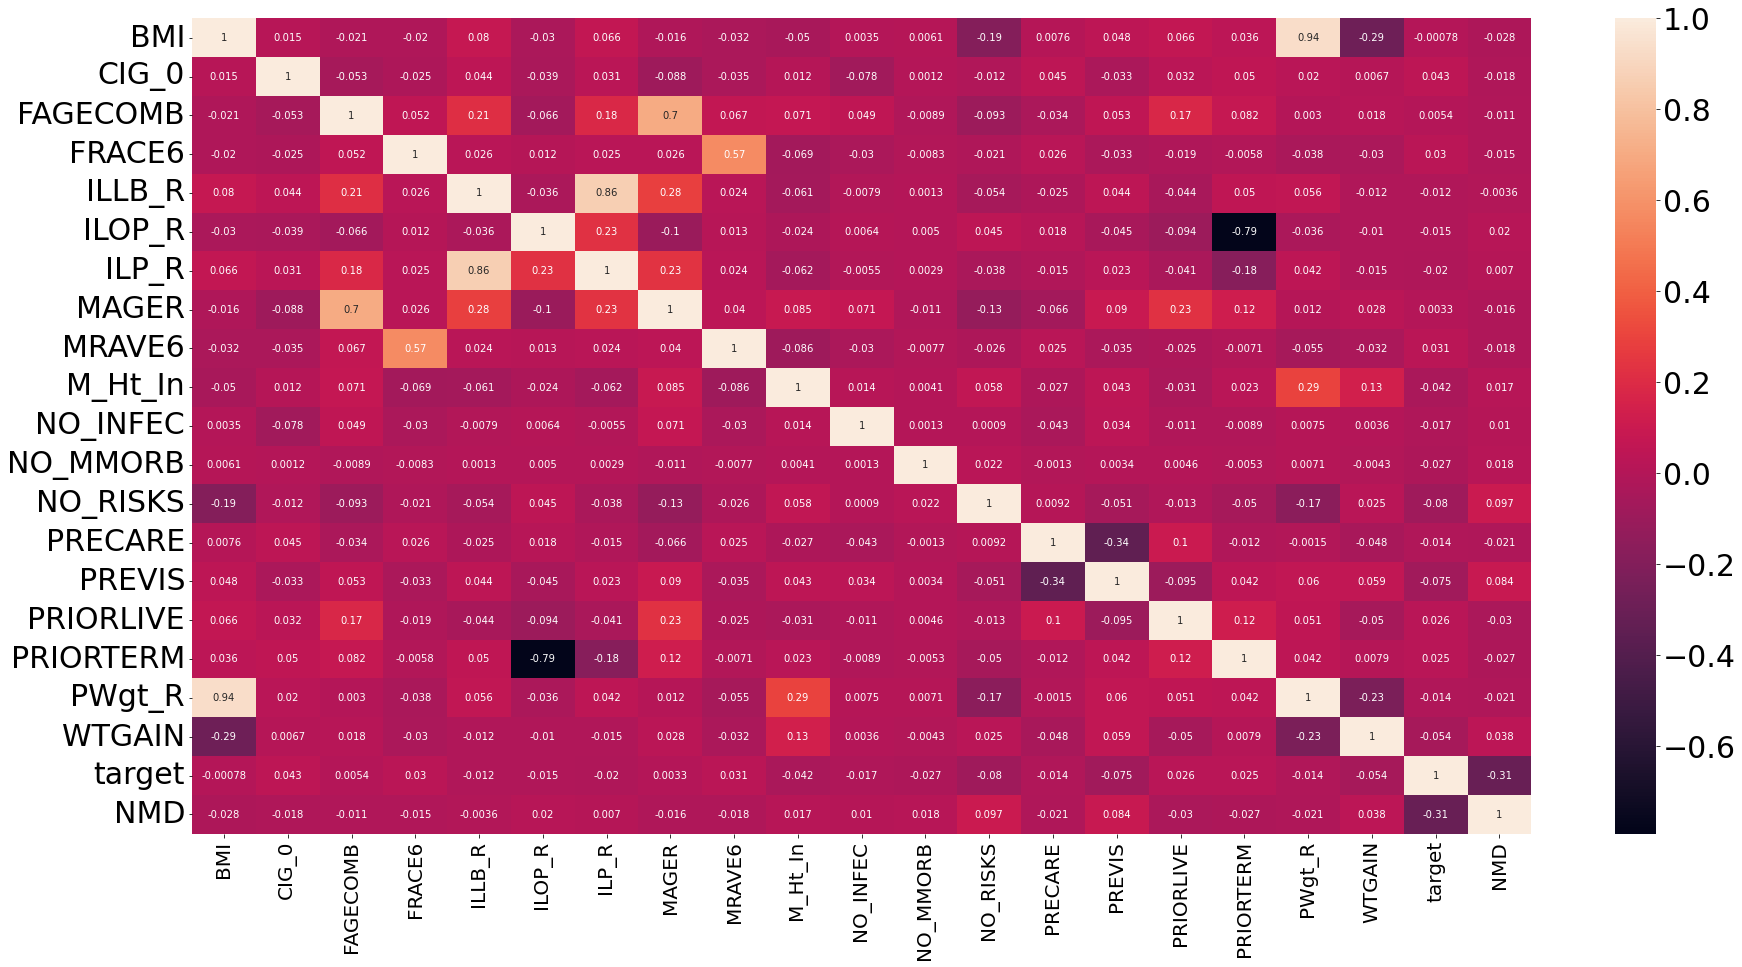

In [19]:
rcParams['figure.figsize'] = 30,15
corrMatrix = df3.corr()
from matplotlib import pyplot as plt
from pylab import rcParams
sns.heatmap(corrMatrix, annot=True)
plt.show()

Analysing some predictors and its relation to the dependant variable by plotting it for the two classes, on the left is the negative class, belonging to the metrics of Normal weight class, and on the right is the positive class, with graphs corresponding to the under weight class.

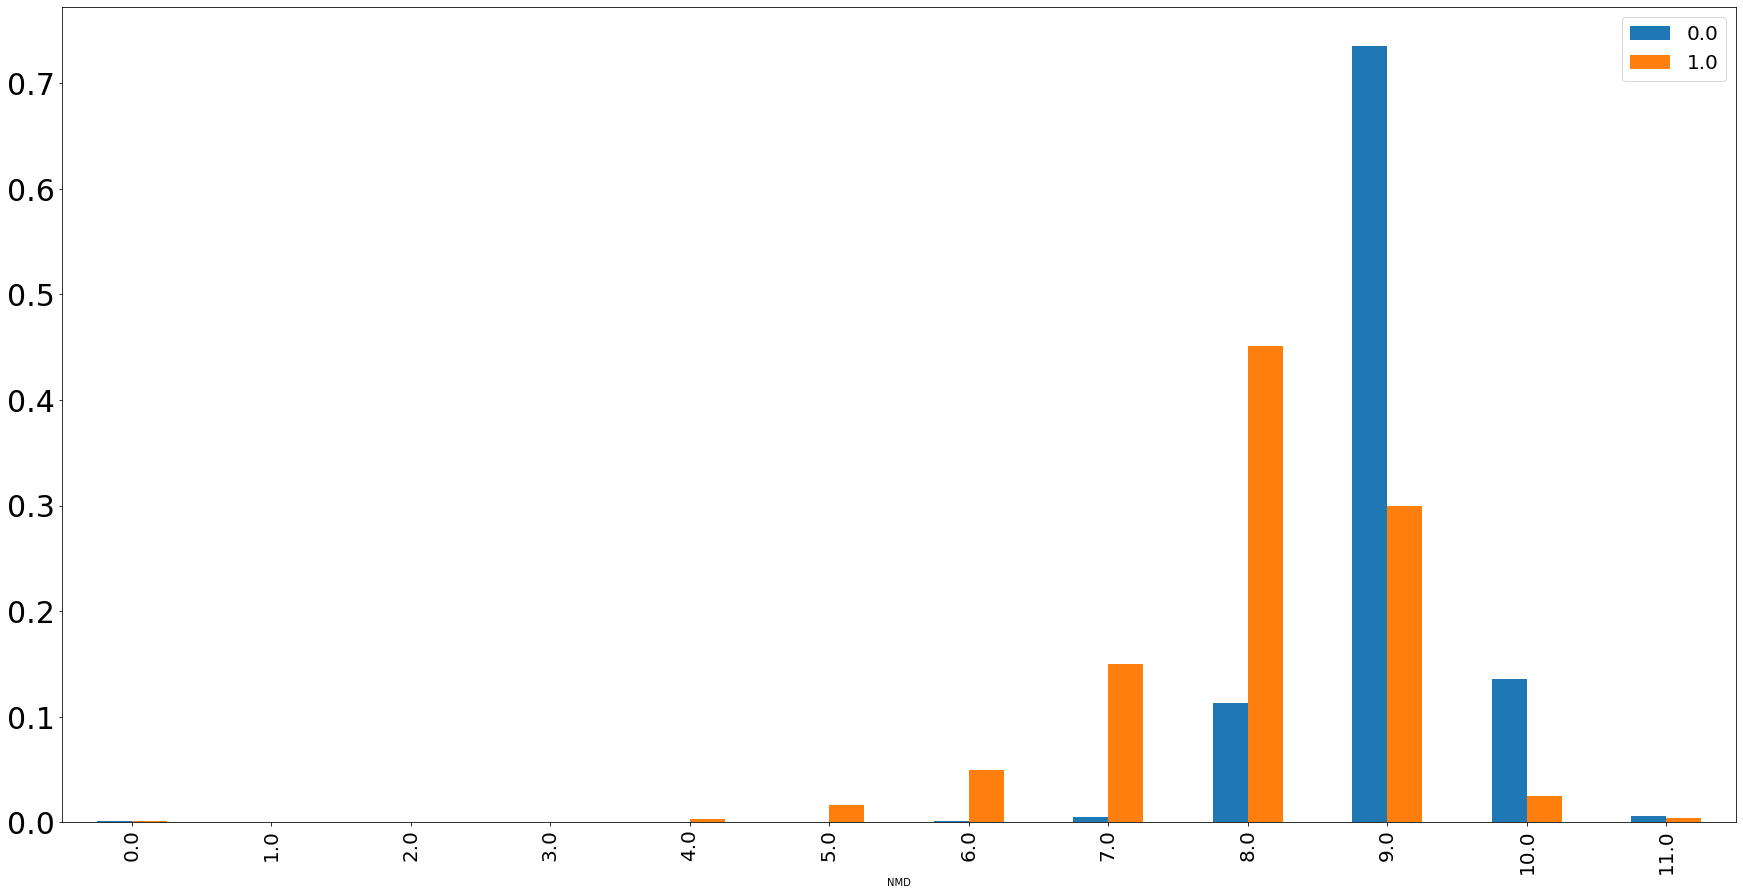

In [21]:

nmd_vs_target = pd.crosstab(df3['NMD'], df3['target'])
total_ratings = nmd_vs_target.apply(sum)
nmd_vs_target /= total_ratings
nmd_vs_target.plot(kind='bar')
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=30)
plt.legend(loc=1, prop={'size': 20})


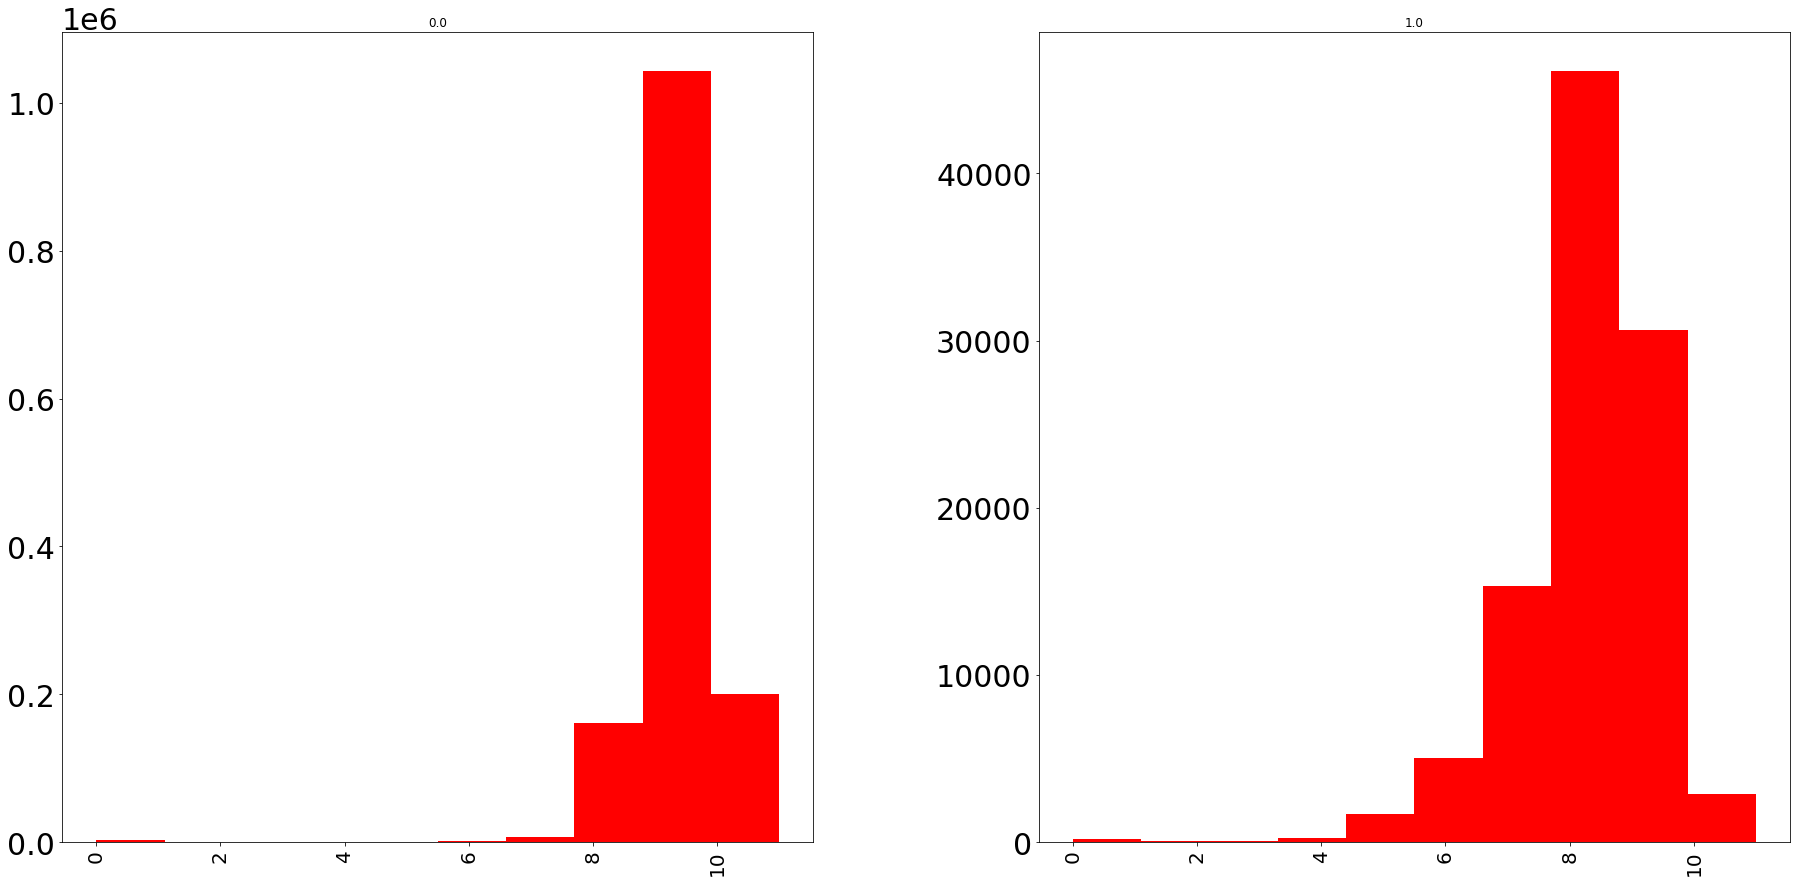

In [22]:
df3['NMD'].hist(by=df3['target'],color='Red')
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=30)


For the mothers who delivered underweight babies, i.e. in the positive class, the instances of NMD value being 6,7,8 is more than the negative class(for babies normal weight). Highest value being 8 in the positive class, showing that women whose normal menstrual cycles stops 6,7, or 8 months before the date of birth have a higher possibility to deliver an underweight baby.

According to https://www.nichd.nih.gov/newsroom/news/050918-early-pregnancy-bleeding#
Women who experience vaginal bleeding for more than one day during the first trimester of pregnancy may be more likely to have a smaller baby, compared to women who do not experience bleeding in the first trimester, suggest researchers at the National Institutes of Health. On average, full-term babies born to women with more than one day of bleeding in the first trimester were about 3 ounces lighter than those born to women with no bleeding during this time. Additionally, infants born to women with more than a day of first trimester bleeding were roughly twice as likely to be small for gestational age, a category that includes infants who are healthy but small, as well as those whose growth has been restricted because of insufficient nutrition or oxygen or other causes.

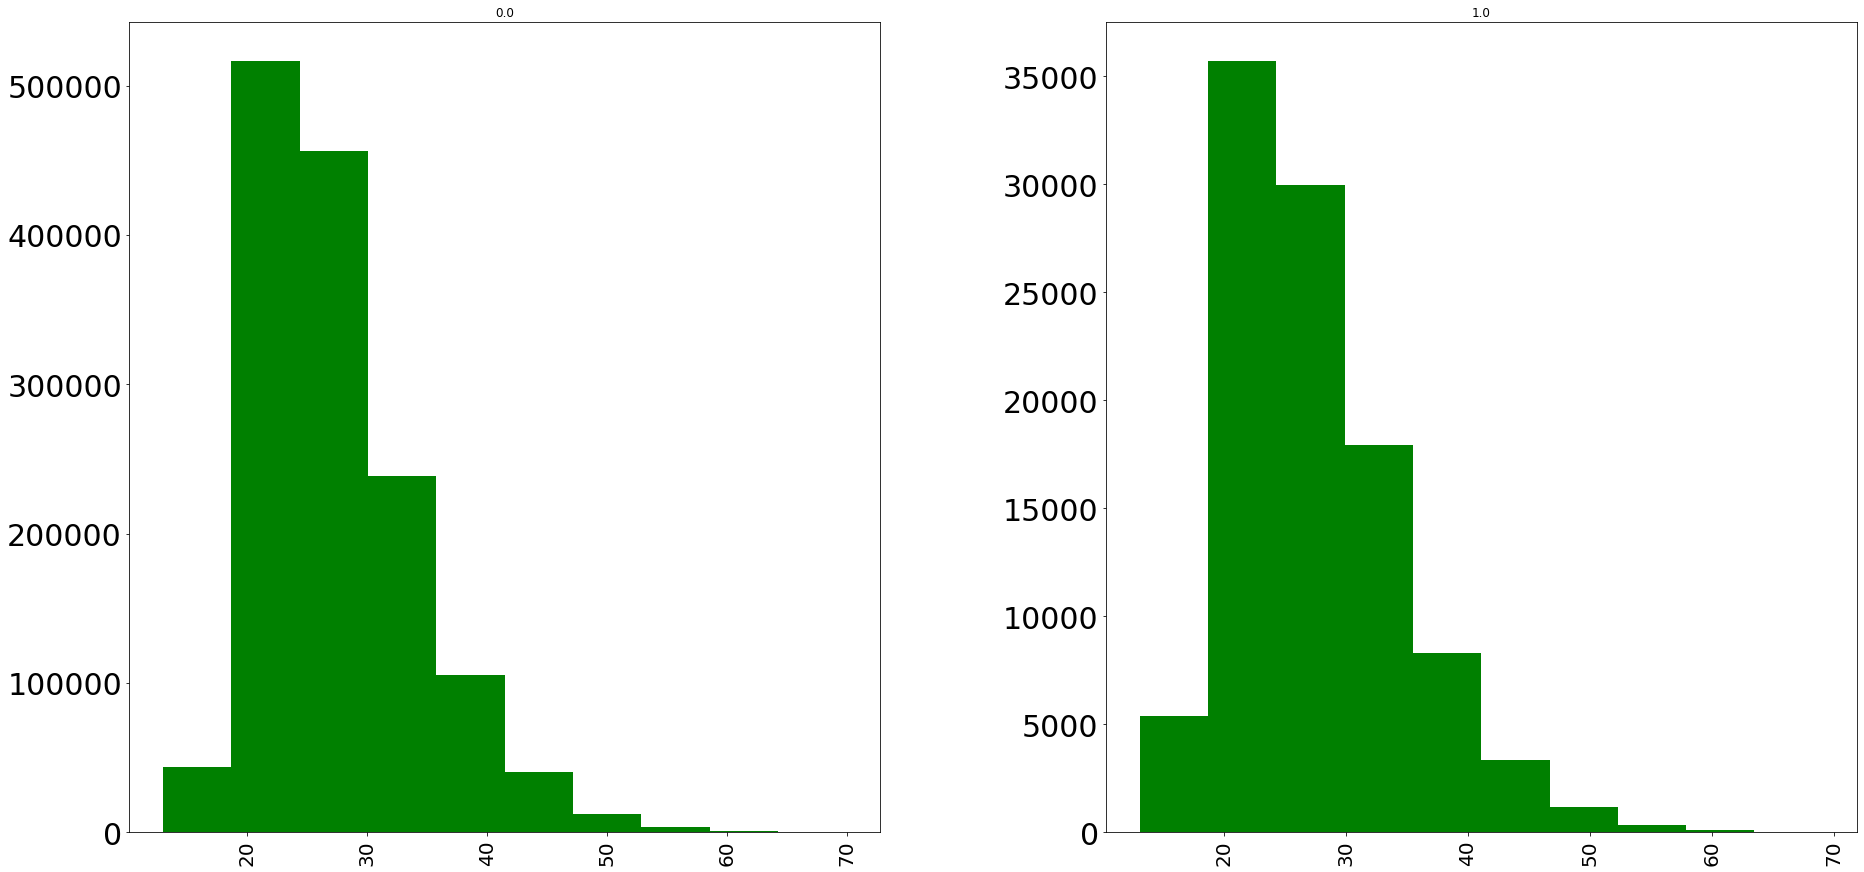

In [24]:
df3['BMI'].hist(by=df3['target'],color='GREEN')
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=30)


Fairly similar plots for BMI for both positive and negative class.

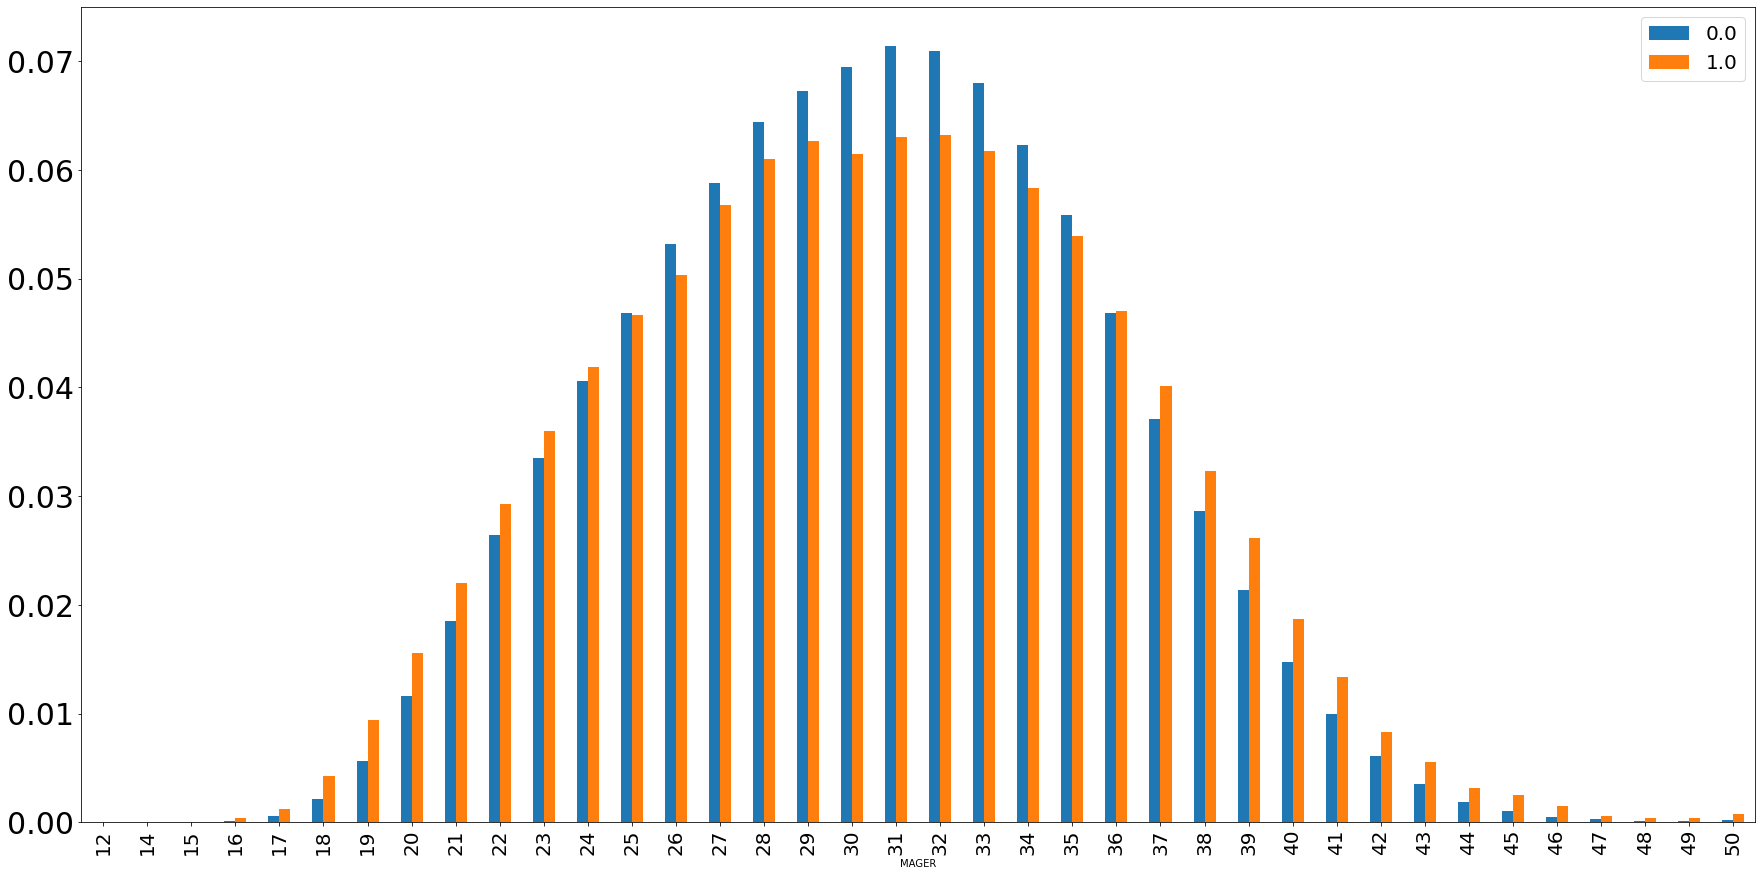

In [25]:
mothersingleage_vs_target = pd.crosstab(df3['MAGER'], df3['target'])
total_ratings = mothersingleage_vs_target.apply(sum)
mothersingleage_vs_target /= total_ratings
mothersingleage_vs_target.plot(kind='bar')
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=30)
plt.legend(loc=1, prop={'size': 20})

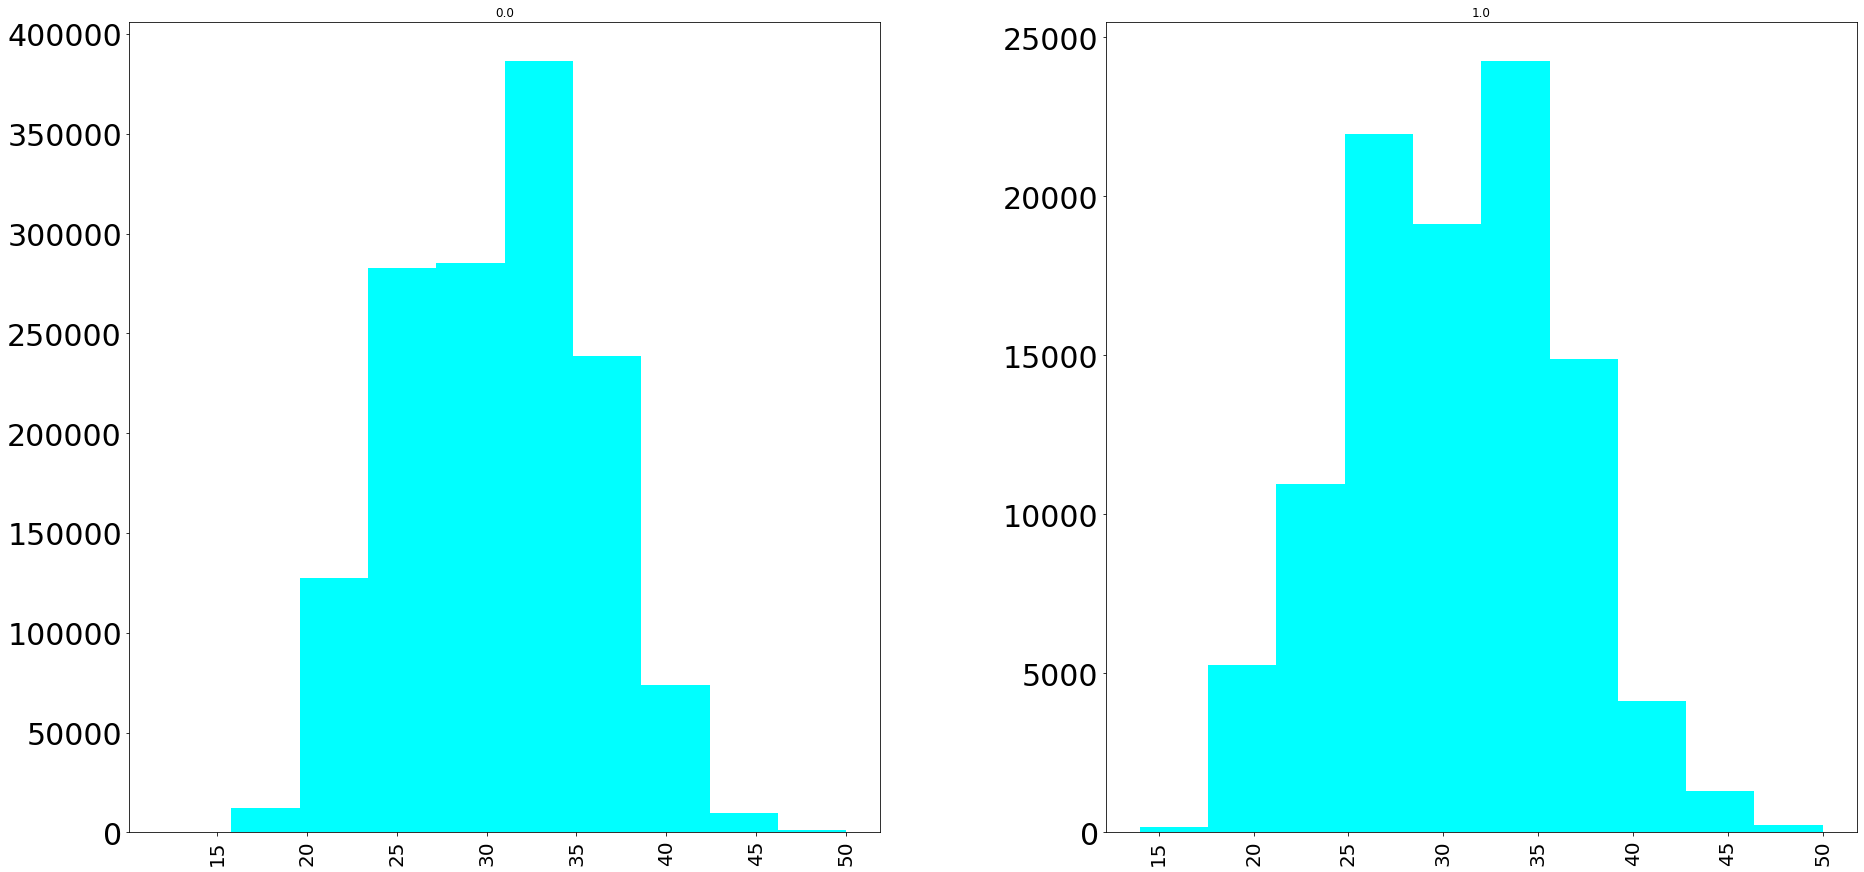

In [26]:
df3['MAGER'].hist(by=df3['target'],color='CYAN')
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=30)

According to our dataset, for mother's age below 24, there is a higher likelyhood for delivering an underweight child than for the age group 25-35. Beyond this age group, the likelyhood of the positive class starts getting higher than the negative class.
Given individual distributions of the positive and negative classes, comparitively a larger deviation is being seen in the two graphs at MAGER = 25 to 27, suggesting that the  group MAGER = 25-30 is more likely to give a normal birth as the distributions of both classes are pretty same.

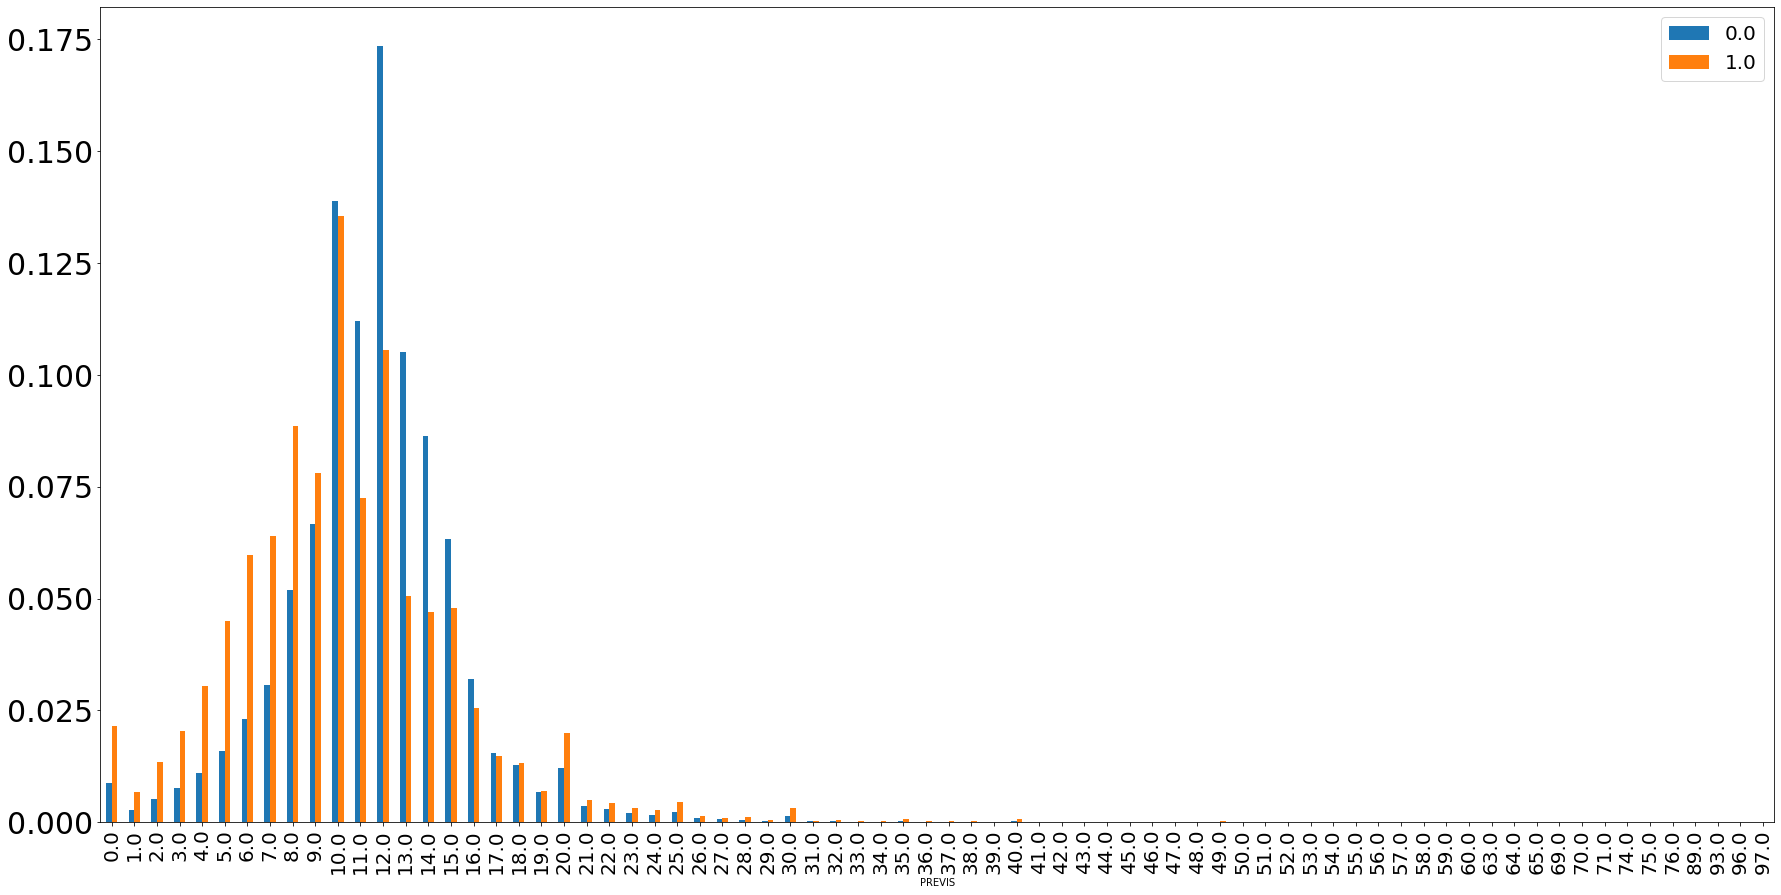

In [27]:
prenatalvisits_vs_target = pd.crosstab(df3['PREVIS'], df3['target'])
total_ratings = prenatalvisits_vs_target.apply(sum)
prenatalvisits_vs_target /= total_ratings
prenatalvisits_vs_target.plot(kind='bar')
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=30)
plt.legend(loc=1, prop={'size': 20})

In [20]:
df3.groupby('target', as_index=False)['PREVIS'].mean()

,target,PREVIS
0,0.0,11.599767
1,1.0,10.405775


As seen in the graph, the positve clas on takes lesser previsits than the negative calss. On average, number of previsits by mothers belonging to the positive class are lesser than those belonging to the negative class.

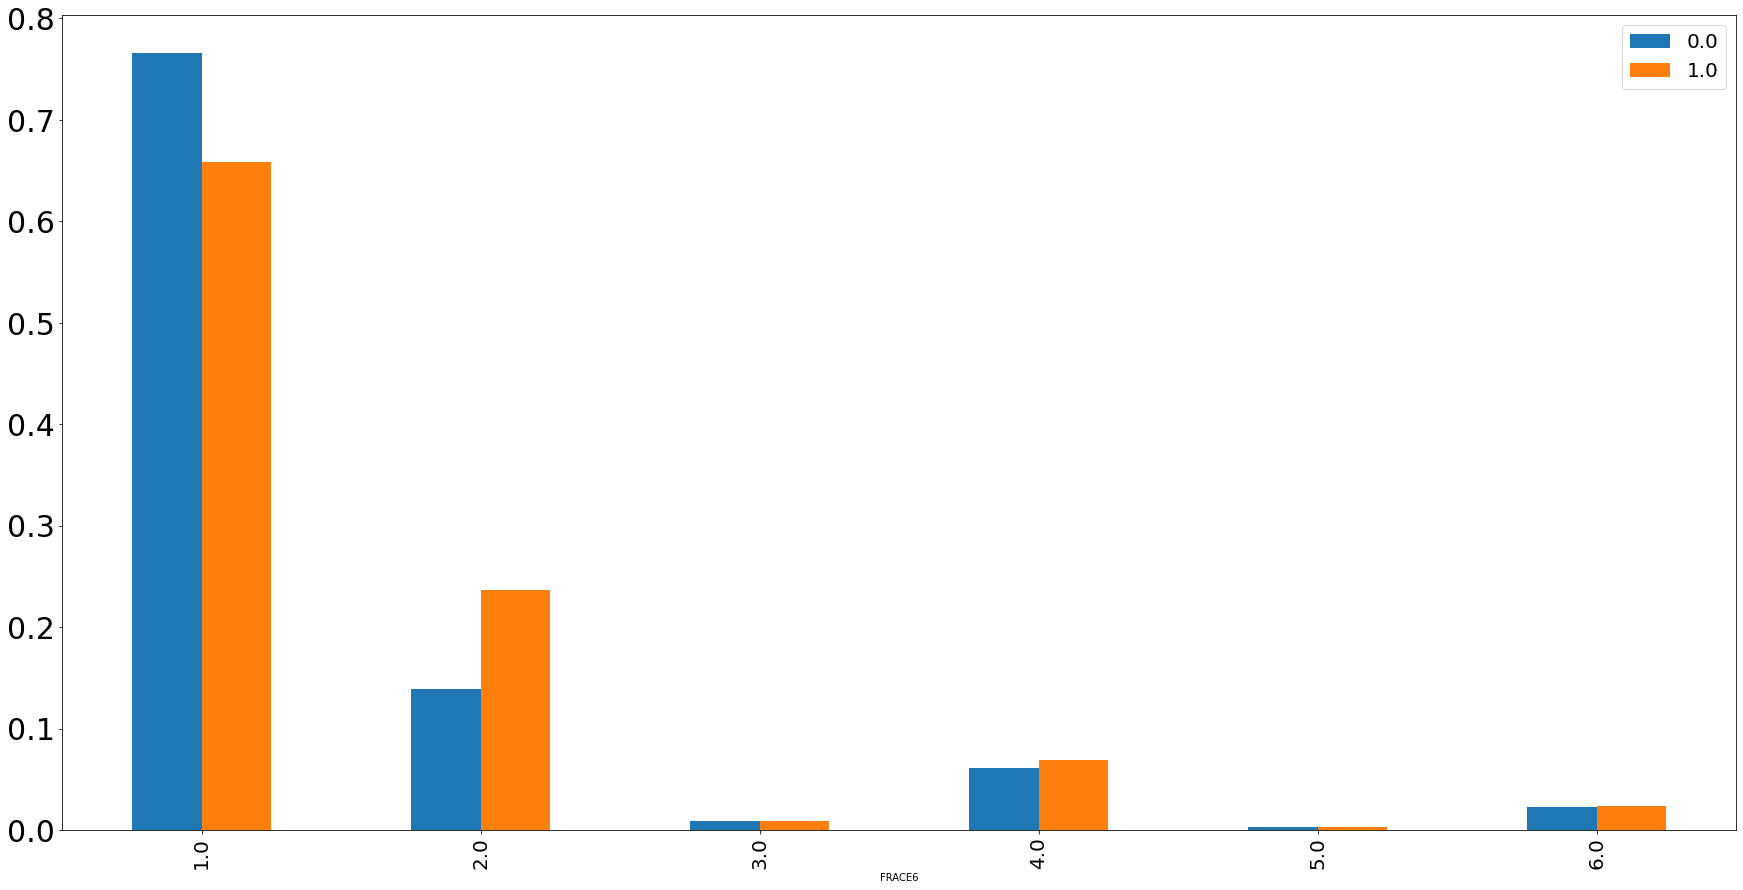

In [29]:
fatherrace_vs_target = pd.crosstab(df3['FRACE6'], df3['target'])
total_ratings = fatherrace_vs_target.apply(sum)
fatherrace_vs_target /= total_ratings
fatherrace_vs_target.plot(kind='bar')
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=30)
plt.legend(loc=1, prop={'size': 20})

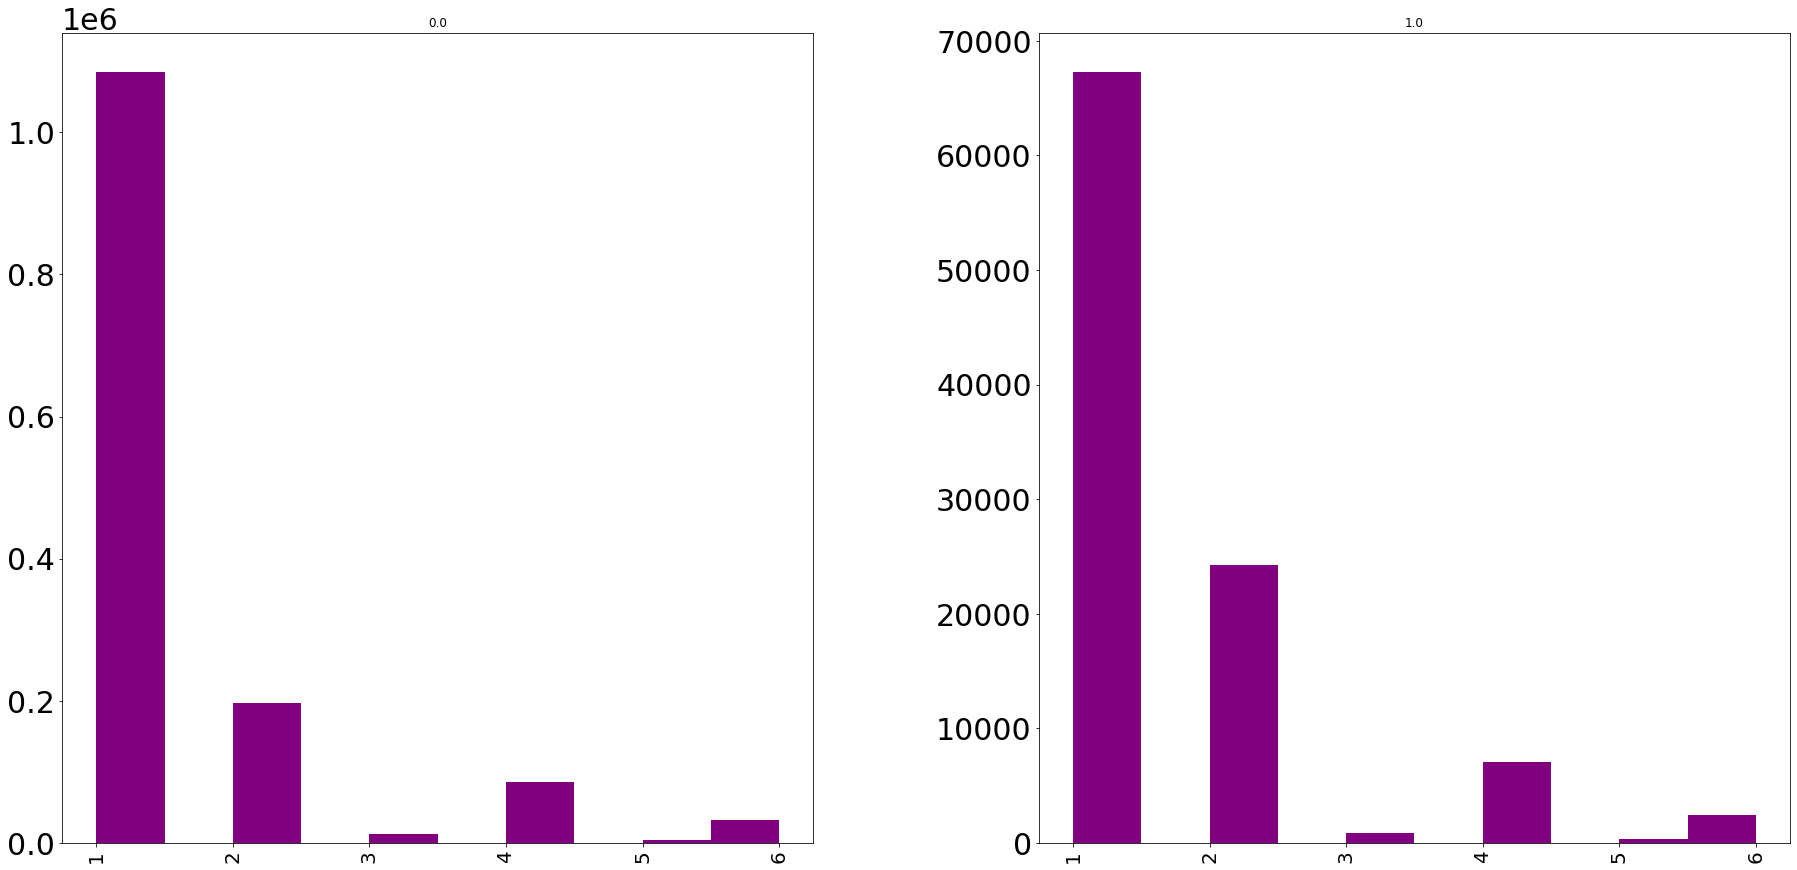

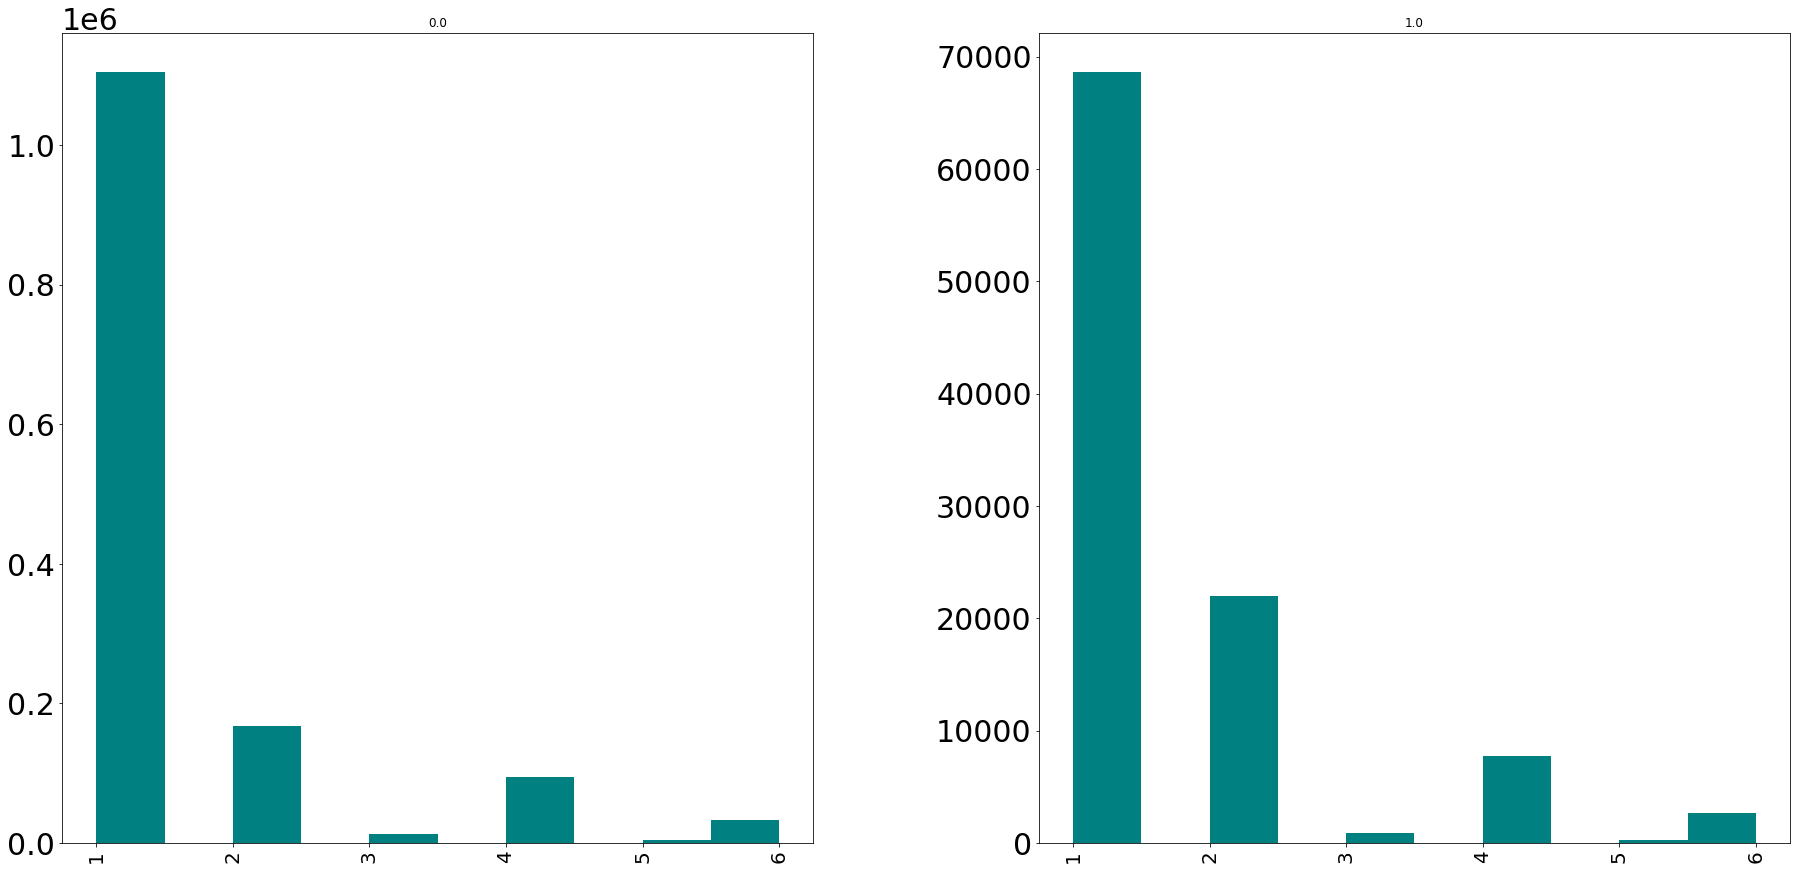

In [31]:
df3['FRACE6'].hist(by=df3['target'],color='purple')
df3['MRAVE6'].hist(by=df3['target'],color='teal')
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=30)

Given individual distributions of the positive and negative classes, comparitively a larger count deviation of Father race being of class 2(black) is being seen in the two graphs and a similar trend is being seen with the mothers race.

In [32]:
df3.groupby('target', as_index=False)['PWgt_R'].mean()

,target,PWgt_R
0,0.0,160.658647
1,1.0,158.292518


On average, the pre-pregnancy weight reported by the mothers in the negative class is lesser than that of the mothers in the positive class.

array([<AxesSubplot:title={'center':'0.0'}>,
       <AxesSubplot:title={'center':'1.0'}>], dtype=object)

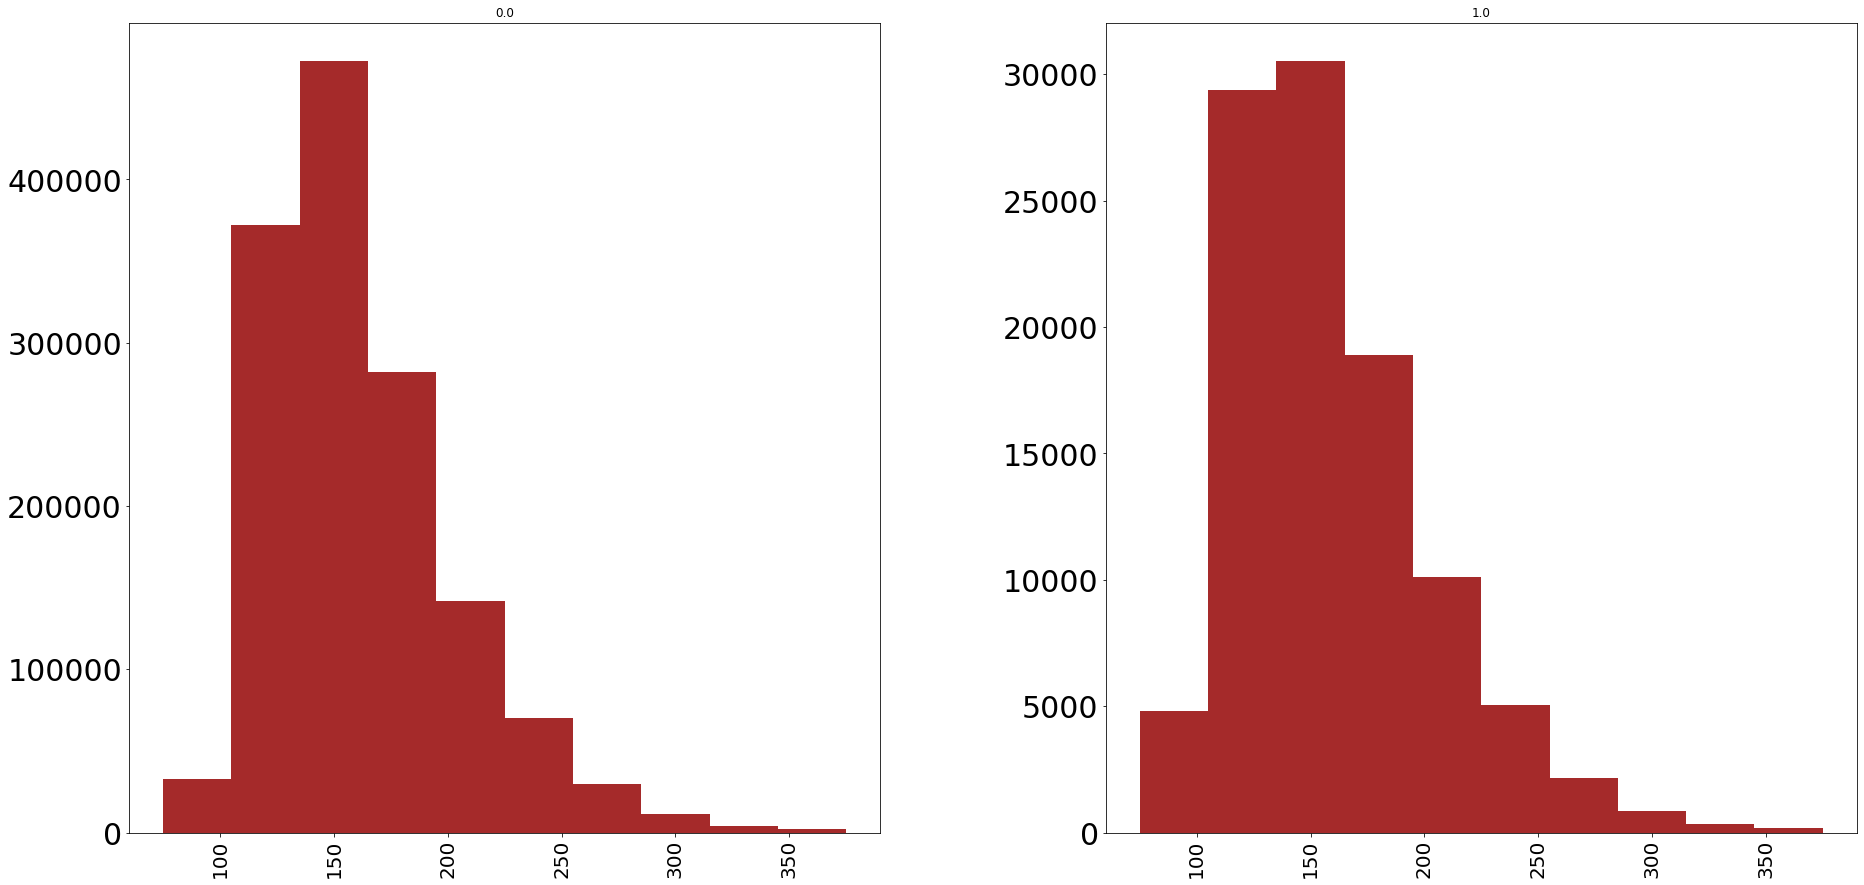

In [33]:
df3['PWgt_R'].hist(by=df3['target'],color='brown')

The above graph confirms the same as there are more women below 100 in the positive class than in the negative class, suggesting pre pregnancy weight of the mother is related to the birth weight of the baby.

<AxesSubplot:xlabel='PRIORLIVE'>

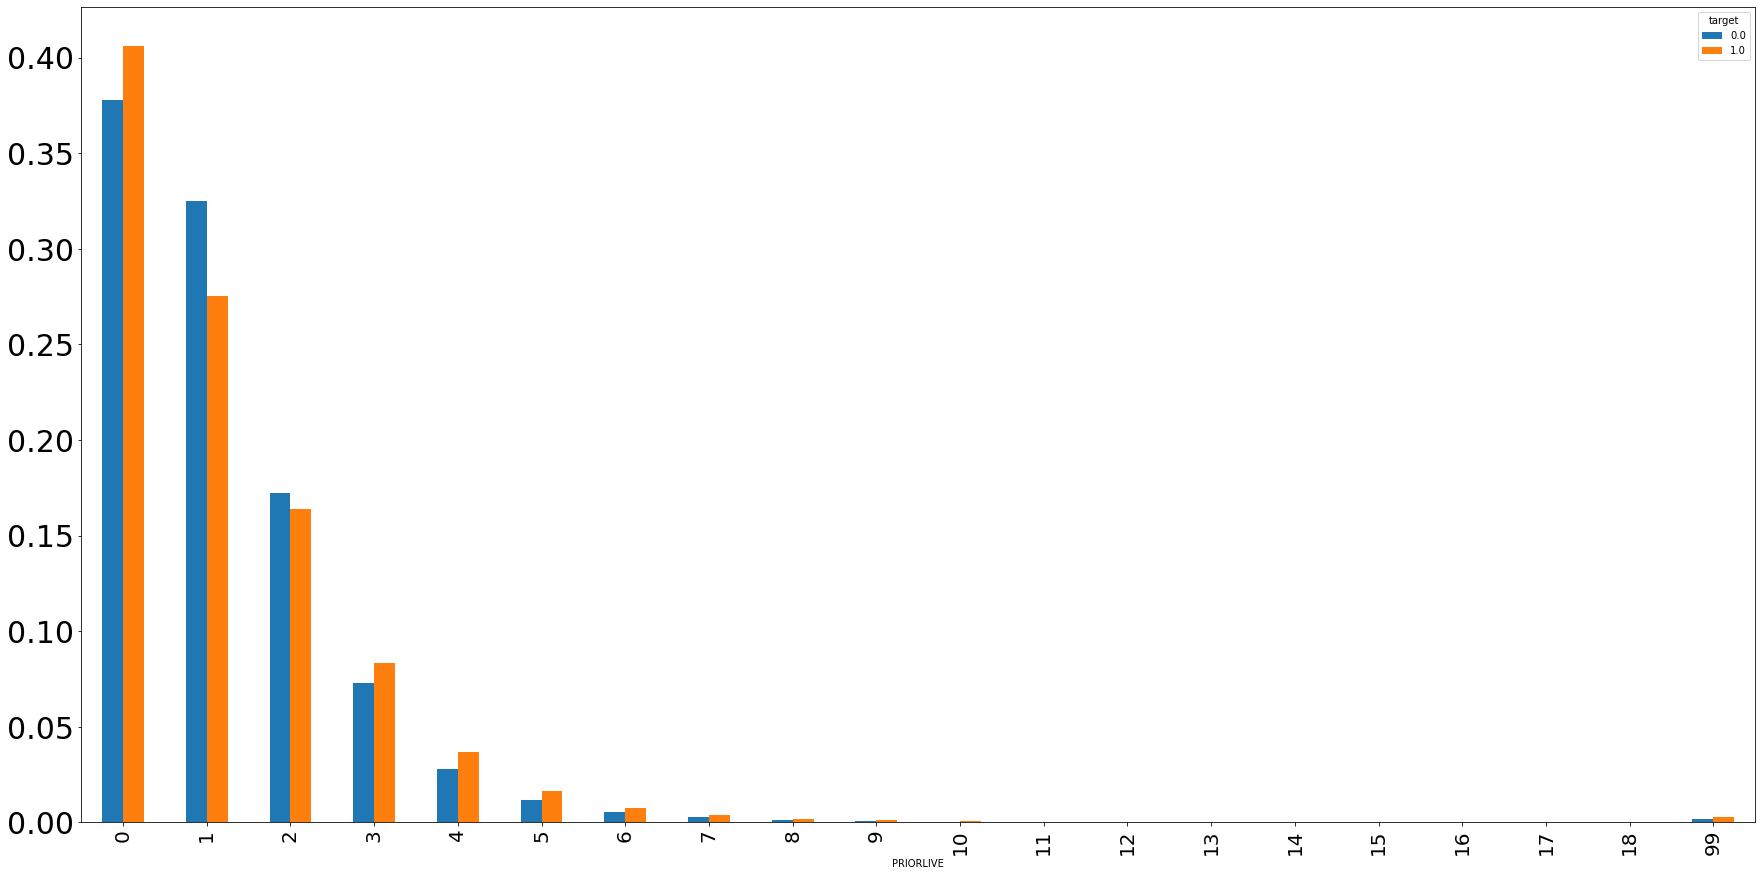

In [55]:
priorlive_vs_target = pd.crosstab(k['PRIORLIVE'], k['target'])
total_ratings = priorlive_vs_target.apply(sum)
priorlive_vs_target /= total_ratings
priorlive_vs_target.plot(kind='bar')

The number of births given by the mother previously show some trend in relating to the birth weight of the child. 
On average, there’s a higher ratio for the first birth to be underweight and its comparatively less likely to deliver an underweight child if you have 1 or 2  previous births. However the likeliness of the positive class increases to 3 or more


# Modeling to predict underweight delivery or not

In [37]:
formula='target ~ BMI + CIG_0 + '\
        'FAGECOMB + C(FRACE6) + ILLB_R + ILOP_R + '\
        'ILP_R + C(IP_GON) + C(LD_INDL) + MAGER + C(MM_AICU) +' \
        'C(MRAVE6) + C(MTRAN) + M_Ht_In + C(NO_INFEC) + C(NO_MMORB) '\
        '+ C(NO_RISKS) + PRECARE + PREVIS +  PRIORLIVE + PRIORTERM + PWgt_R + C(SEX) + WTGAIN + NMD'

In [38]:
Y, X = dmatrices(formula, df3, return_type='dataframe')
y = Y['target'].values

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [40]:
#resampling training data to 10000 rows to ensure computational feasibility for complex models like gradient boosting
#X_train,y_train=resample(X_train,y_train, n_samples=10000, replace=False, stratify=y_train, random_state=18)

In [41]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)

/Users/pratikgawli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
from sklearn import metrics

prediction_train = model.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train),recall_score(y_train,prediction_train))

0.9336218698935653 0.06420296148943026


In [43]:
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction),recall_score(y_test,prediction))

0.9330468433111523 0.06398188581594695


The accuracy with logistic regression is better than the baseline(93.27%) but the recall is only 6%. Lets try to improve it by upsampling the positive class in the training set.

In [44]:
from imblearn.over_sampling import SMOTE, ADASYN
X_trainLR, y_trainLR=SMOTE().fit_resample(X_train, y_train)

In [48]:
model = LogisticRegression()
result = model.fit(X_trainLR, y_trainLR)

/Users/pratikgawli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
prediction_train = model.predict(X_trainLR)
print(metrics.accuracy_score(y_trainLR, prediction_train),recall_score(y_trainLR,prediction_train))

0.777652547545521 0.742560216268918


In [50]:
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction),recall_score(y_test,prediction))

0.8049551080367029 0.701956978812874


Logistic regression accuracy on the test data with upsampling is : 80%, and recall has improved significantly to 70%. However accuracy takes a hit. We will test other models without the upsampling as it is affecting the accuracy.

In [74]:
# All the models we want to test out
models = {}
models['Decision Tree'] = \
    tree.DecisionTreeClassifier(criterion='entropy')

models['Bagging'] = \
    BaggingClassifier(
        tree.DecisionTreeClassifier(criterion='entropy'),
        random_state=1)

models['Random Forest'] = \
    RandomForestClassifier(n_estimators=15,
                           random_state=18)

models['Gradient Boosting'] = \
    GradientBoostingClassifier(n_estimators=800,
                               max_depth=4,
                               random_state=18)

In [75]:
for name, model in models.items():
    print('Fitting', name)
    model.fit(X_train, y_train)

Fitting Decision Tree
Fitting Bagging
Fitting Random Forest
Fitting Gradient Boosting


In [76]:
recall_train={}
recall_test={}
accuracy_train = {}
accuracy_test = {}
target_names = ['Normal weight', 'Under Weight']
for name, model in models.items():
    prediction_train = model.predict(X_train)
    accuracy_train[name] = metrics.accuracy_score(y_train, prediction_train)
    recall_train[name]= recall_score(y_train, prediction_train, average='macro')
    prediction_test = model.predict(X_test)
    accuracy_test[name] = metrics.accuracy_score(y_test, prediction_test)
    recall_test[name]= recall_score(y_test, prediction_test, average='macro')
    print(classification_report(y_test, prediction_test, target_names=target_names))
    
df = pd.DataFrame({'Training Accuracy':accuracy_train, 'Test Accuracy':accuracy_test,'Train Recall':recall_train,'Test Recall':recall_test })
df

               precision    recall  f1-score   support

Normal weight       0.95      0.95      0.95    425180
 Under Weight       0.35      0.38      0.36     30915

     accuracy                           0.91    456095
    macro avg       0.65      0.66      0.66    456095
 weighted avg       0.91      0.91      0.91    456095

               precision    recall  f1-score   support

Normal weight       0.95      0.99      0.97    425180
 Under Weight       0.70      0.31      0.43     30915

     accuracy                           0.94    456095
    macro avg       0.83      0.65      0.70    456095
 weighted avg       0.93      0.94      0.93    456095

               precision    recall  f1-score   support

Normal weight       0.95      0.99      0.97    425180
 Under Weight       0.71      0.32      0.44     30915

     accuracy                           0.94    456095
    macro avg       0.83      0.66      0.71    456095
 weighted avg       0.94      0.94      0.94    456095

 

,Training Accuracy,Test Accuracy,Train Recall,Test Recall
Decision Tree,0.999702,0.909363,0.997793,0.663241
Bagging,0.991854,0.944141,0.941125,0.649335
Random Forest,0.996556,0.944948,0.975772,0.655332
Gradient Boosting,0.948699,0.946601,0.665170,0.658768


In [77]:
importances = models['Random Forest'].feature_importances_
sorted_indices = np.argsort(importances)[::-1]

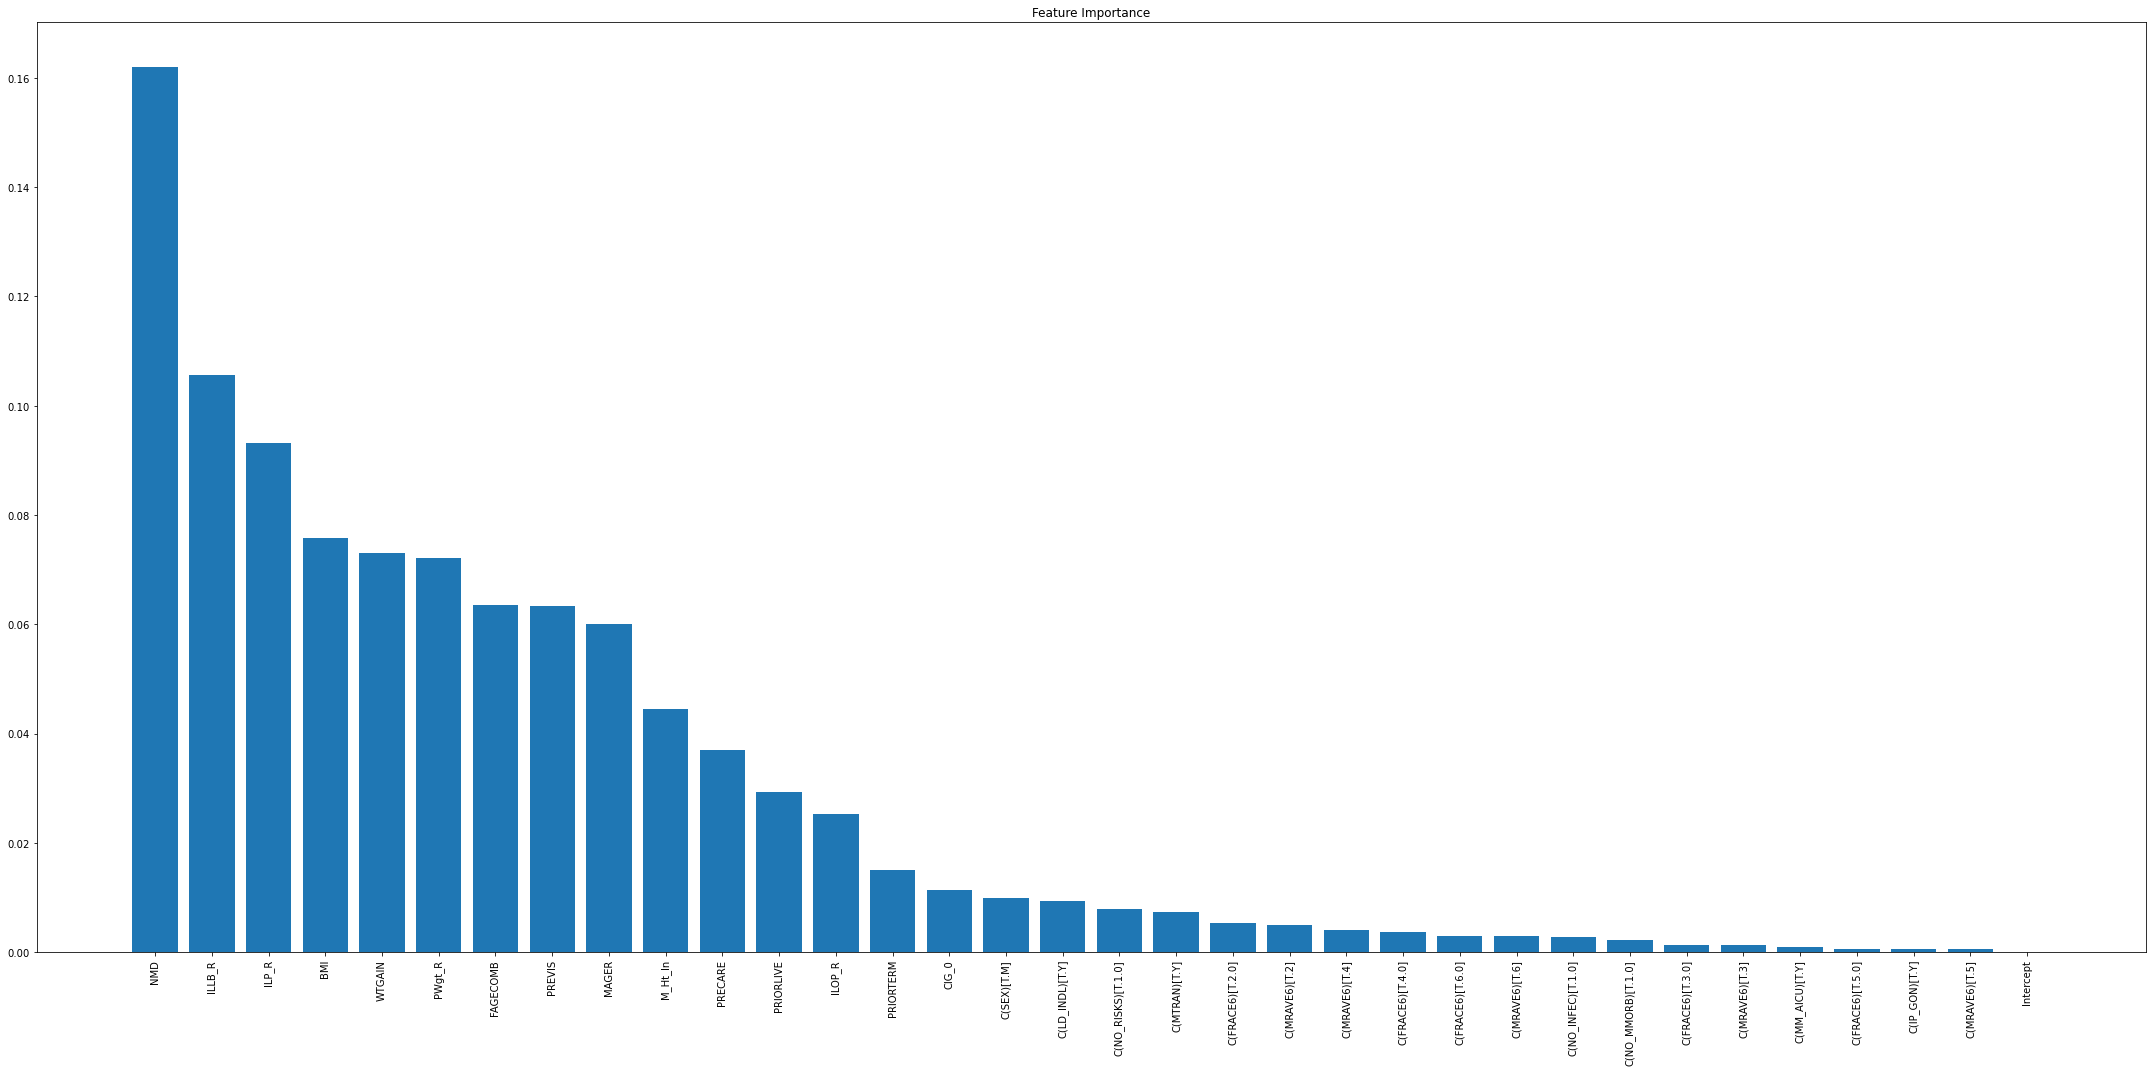

In [78]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
rcParams['figure.figsize'] = 30,15
plt.show()

# Inference


Mother's current physical factors affecting the birth weight of the child:
1. Mothers height in inches
2. BMI
3. Prepregnancy Weight
4. Weight gained during pregnancy.

Mother's medical related factors affecting birth weight of the child:
1. NMD - most important factor based on our data
2. Interval since last pregnancy/last birth/other pregnancy.
3. Mothers single age.

Other miscellaneous factors:
1. Fathers age
2. Number of prenatal visits
3. When did the prenatal care begin
4. Prior births which are now living
5. Number of Cigarettes smoked during pregnancy.

All other factors play comparitively lesser important role in determining the weight of the child.
